Given an image like the example below, your goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [ ]:
!nvidia-smi

Fri May 13 09:57:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections #把檔案名稱串起來的工具
import random
import numpy as np
import os
import time #呼叫時間
import json 
from PIL import Image #影響處裡常用的套件
from tqdm import tqdm

## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train your model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/' #設定放 json 的位置，會開一個新的資料夾
if not os.path.exists(os.path.abspath('.') + annotation_folder): # .是當前的位置
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/' #set training data 放的位置
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 210s 0us/step


## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train your model. Choosing to use more data would result in improved captioning quality.

In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
annotations.keys() #查看 json 裡面有甚麼東西

dict_keys(['info', 'images', 'licenses', 'annotations'])

In [ ]:
annotations['info']
annotations['annotations']

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list) #創一個存變數的位置
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id']) #找圖片位置
  image_path_to_caption[image_path].append(caption)

In [ ]:
image_path_to_caption

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths) #一次挑幾張圖片

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A small train is driving down the dirt road. <end>


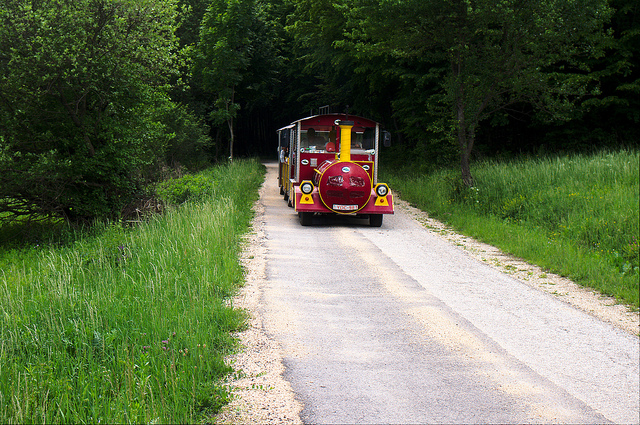

In [ ]:
print(train_captions[55]) # 一張圖片有 4 個句子，所以要到第五張才會是新的圖片
Image.open(img_name_vector[55])

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3) #讀檔
    img = tf.keras.layers.Resizing(299, 299)(img) #resize
    img = tf.keras.applications.inception_v3.preprocess_input(img) #這裡用 pretrained model，他有特定的 prerocess
    return img, image_path

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False, #不要 V3 的最後一層
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output # 8*8*20148 最終outputs的長相

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
image_features_extract_model.summary()

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16) #一個 batch 讀 16張

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy()) #直接將處理好的圖片存成npy黨

100%|██████████| 375/375 [02:22<00:00,  2.64it/s]


In [ ]:
path

## Preprocess and tokenize the captions

You will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top 5,000 words (to save memory).
* Tokenize all captions by mapping each word to it's index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs) #把所有英文轉小寫
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "") #將標點符號用空格替代

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(  #製造一個 5000 字的字典檔
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset) #把字灌入字典檔

In [ ]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
caption_dataset #一條文字

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
cap_vector #把一串字用 vector 表示

<MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int64, name=None)>

In [ ]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup( #之後看檔案比較方便
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

## Split the data into training and testing

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector): #img_name_vector, cap_vector 都是 vector
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = [] 
for imgt in img_name_train_keys: #切 training data
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys: #切 validation data  
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24009, 24009, 6003, 6003)

## Create a tf.data dataset for training


Your images and captions are ready! Next, let's create a `tf.data` dataset to use for training your model.

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512 #
num_steps = len(img_name_train) // BATCH_SIZE #一個 epochs 要做跑幾次
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [ ]:
class BahdanauAttention(tf.keras.Model): #某種 attention
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units) #兩兩向量對乘
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features #一條條 vector 做加權的結果
    context_vector = tf.reduce_sum(context_vector, axis=1) 

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units, #GRU 簡化版的 LSTM
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units) #512
    self.fc2 = tf.keras.layers.Dense(vocab_size) #5000 希望 output 的結果是字點檔的字，所以會是一個5000個的分類問題

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy( #是一個 5000 類的分類問題
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 30

for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 1.9957
Epoch 1 Batch 100 Loss 1.0693
Epoch 1 Batch 200 Loss 0.9546
Epoch 1 Batch 300 Loss 0.9231


  3%|▎         | 1/30 [05:12<2:31:14, 312.90s/it]

Epoch 1 Loss 1.024933
Time taken for 1 epoch 312.90 sec

Epoch 2 Batch 0 Loss 0.9381
Epoch 2 Batch 100 Loss 0.7480
Epoch 2 Batch 200 Loss 0.7071
Epoch 2 Batch 300 Loss 0.7428


  7%|▋         | 2/30 [08:07<1:47:57, 231.35s/it]

Epoch 2 Loss 0.775009
Time taken for 1 epoch 174.26 sec

Epoch 3 Batch 0 Loss 0.7379
Epoch 3 Batch 100 Loss 0.6643
Epoch 3 Batch 200 Loss 0.6818
Epoch 3 Batch 300 Loss 0.6896


 10%|█         | 3/30 [11:01<1:32:19, 205.15s/it]

Epoch 3 Loss 0.698809
Time taken for 1 epoch 173.97 sec

Epoch 4 Batch 0 Loss 0.6529
Epoch 4 Batch 100 Loss 0.7092
Epoch 4 Batch 200 Loss 0.6179
Epoch 4 Batch 300 Loss 0.5969


 13%|█▎        | 4/30 [13:55<1:23:35, 192.90s/it]

Epoch 4 Loss 0.649326
Time taken for 1 epoch 174.12 sec

Epoch 5 Batch 0 Loss 0.6820
Epoch 5 Batch 100 Loss 0.6052
Epoch 5 Batch 200 Loss 0.5690
Epoch 5 Batch 300 Loss 0.6233


 17%|█▋        | 5/30 [16:49<1:17:36, 186.27s/it]

Epoch 5 Loss 0.610389
Time taken for 1 epoch 174.51 sec

Epoch 6 Batch 0 Loss 0.6114
Epoch 6 Batch 100 Loss 0.5813
Epoch 6 Batch 200 Loss 0.5371
Epoch 6 Batch 300 Loss 0.5616


 20%|██        | 6/30 [20:11<1:16:39, 191.65s/it]

Epoch 6 Loss 0.577015
Time taken for 1 epoch 202.10 sec

Epoch 7 Batch 0 Loss 0.5808
Epoch 7 Batch 100 Loss 0.5482
Epoch 7 Batch 200 Loss 0.5699
Epoch 7 Batch 300 Loss 0.6042


 23%|██▎       | 7/30 [23:06<1:11:16, 185.94s/it]

Epoch 7 Loss 0.546699
Time taken for 1 epoch 174.17 sec

Epoch 8 Batch 0 Loss 0.6283
Epoch 8 Batch 100 Loss 0.5222
Epoch 8 Batch 200 Loss 0.5042
Epoch 8 Batch 300 Loss 0.5343


 27%|██▋       | 8/30 [26:00<1:06:49, 182.25s/it]

Epoch 8 Loss 0.517984
Time taken for 1 epoch 174.36 sec

Epoch 9 Batch 0 Loss 0.5036
Epoch 9 Batch 100 Loss 0.4412
Epoch 9 Batch 200 Loss 0.4887
Epoch 9 Batch 300 Loss 0.5111


 30%|███       | 9/30 [28:54<1:02:54, 179.73s/it]

Epoch 9 Loss 0.491222
Time taken for 1 epoch 174.18 sec

Epoch 10 Batch 0 Loss 0.4962
Epoch 10 Batch 100 Loss 0.4826
Epoch 10 Batch 200 Loss 0.4725
Epoch 10 Batch 300 Loss 0.4332


 33%|███▎      | 10/30 [31:48<59:18, 177.94s/it] 

Epoch 10 Loss 0.465128
Time taken for 1 epoch 173.94 sec

Epoch 11 Batch 0 Loss 0.4618
Epoch 11 Batch 100 Loss 0.4729
Epoch 11 Batch 200 Loss 0.4481
Epoch 11 Batch 300 Loss 0.4257


 37%|███▋      | 11/30 [34:42<56:00, 176.86s/it]

Epoch 11 Loss 0.439992
Time taken for 1 epoch 174.42 sec

Epoch 12 Batch 0 Loss 0.4457
Epoch 12 Batch 100 Loss 0.4252
Epoch 12 Batch 200 Loss 0.4160
Epoch 12 Batch 300 Loss 0.4531


 40%|████      | 12/30 [37:37<52:48, 176.05s/it]

Epoch 12 Loss 0.416790
Time taken for 1 epoch 174.18 sec

Epoch 13 Batch 0 Loss 0.4466
Epoch 13 Batch 100 Loss 0.4125
Epoch 13 Batch 200 Loss 0.3859
Epoch 13 Batch 300 Loss 0.3981


 43%|████▎     | 13/30 [40:31<49:45, 175.59s/it]

Epoch 13 Loss 0.395268
Time taken for 1 epoch 174.54 sec

Epoch 14 Batch 0 Loss 0.4010
Epoch 14 Batch 100 Loss 0.4112
Epoch 14 Batch 200 Loss 0.3577
Epoch 14 Batch 300 Loss 0.3751


 47%|████▋     | 14/30 [43:25<46:42, 175.14s/it]

Epoch 14 Loss 0.375469
Time taken for 1 epoch 174.10 sec

Epoch 15 Batch 0 Loss 0.3989
Epoch 15 Batch 100 Loss 0.3471
Epoch 15 Batch 200 Loss 0.3385
Epoch 15 Batch 300 Loss 0.3567


 50%|█████     | 15/30 [46:19<43:40, 174.68s/it]

Epoch 15 Loss 0.354110
Time taken for 1 epoch 173.61 sec

Epoch 16 Batch 0 Loss 0.3437
Epoch 16 Batch 100 Loss 0.3433
Epoch 16 Batch 200 Loss 0.3314
Epoch 16 Batch 300 Loss 0.3134


 53%|█████▎    | 16/30 [49:12<40:40, 174.33s/it]

Epoch 16 Loss 0.334978
Time taken for 1 epoch 173.53 sec

Epoch 17 Batch 0 Loss 0.3152
Epoch 17 Batch 100 Loss 0.3236
Epoch 17 Batch 200 Loss 0.2975
Epoch 17 Batch 300 Loss 0.2818


 57%|█████▋    | 17/30 [52:06<37:43, 174.08s/it]

Epoch 17 Loss 0.318239
Time taken for 1 epoch 173.49 sec

Epoch 18 Batch 0 Loss 0.3382
Epoch 18 Batch 100 Loss 0.3001
Epoch 18 Batch 200 Loss 0.2736
Epoch 18 Batch 300 Loss 0.3110


 60%|██████    | 18/30 [55:00<34:48, 174.04s/it]

Epoch 18 Loss 0.302967
Time taken for 1 epoch 173.93 sec

Epoch 19 Batch 0 Loss 0.3461
Epoch 19 Batch 100 Loss 0.2838
Epoch 19 Batch 200 Loss 0.2868
Epoch 19 Batch 300 Loss 0.2824


 63%|██████▎   | 19/30 [57:53<31:52, 173.85s/it]

Epoch 19 Loss 0.289558
Time taken for 1 epoch 173.41 sec

Epoch 20 Batch 0 Loss 0.2854
Epoch 20 Batch 100 Loss 0.2574
Epoch 20 Batch 200 Loss 0.2561
Epoch 20 Batch 300 Loss 0.2603


 67%|██████▋   | 20/30 [1:00:47<28:57, 173.73s/it]

Epoch 20 Loss 0.276253
Time taken for 1 epoch 173.44 sec

Epoch 21 Batch 0 Loss 0.2605
Epoch 21 Batch 100 Loss 0.2597
Epoch 21 Batch 200 Loss 0.2462
Epoch 21 Batch 300 Loss 0.2633


 70%|███████   | 21/30 [1:03:41<26:03, 173.75s/it]

Epoch 21 Loss 0.262365
Time taken for 1 epoch 173.81 sec

Epoch 22 Batch 0 Loss 0.3107
Epoch 22 Batch 100 Loss 0.2371
Epoch 22 Batch 200 Loss 0.2598
Epoch 22 Batch 300 Loss 0.2713


 73%|███████▎  | 22/30 [1:06:34<23:10, 173.80s/it]

Epoch 22 Loss 0.253147
Time taken for 1 epoch 173.89 sec

Epoch 23 Batch 0 Loss 0.2450
Epoch 23 Batch 100 Loss 0.2404
Epoch 23 Batch 200 Loss 0.2273
Epoch 23 Batch 300 Loss 0.2350


 77%|███████▋  | 23/30 [1:09:28<20:16, 173.77s/it]

Epoch 23 Loss 0.241758
Time taken for 1 epoch 173.70 sec

Epoch 24 Batch 0 Loss 0.2724
Epoch 24 Batch 100 Loss 0.2182
Epoch 24 Batch 200 Loss 0.2026
Epoch 24 Batch 300 Loss 0.2345


 80%|████████  | 24/30 [1:12:22<17:22, 173.70s/it]

Epoch 24 Loss 0.231516
Time taken for 1 epoch 173.52 sec

Epoch 25 Batch 0 Loss 0.2461
Epoch 25 Batch 100 Loss 0.2193
Epoch 25 Batch 200 Loss 0.2190
Epoch 25 Batch 300 Loss 0.2186


 83%|████████▎ | 25/30 [1:15:16<14:29, 173.83s/it]

Epoch 25 Loss 0.225135
Time taken for 1 epoch 174.14 sec

Epoch 26 Batch 0 Loss 0.2545
Epoch 26 Batch 100 Loss 0.2163
Epoch 26 Batch 200 Loss 0.2130
Epoch 26 Batch 300 Loss 0.2333


 87%|████████▋ | 26/30 [1:18:10<11:35, 173.82s/it]

Epoch 26 Loss 0.216748
Time taken for 1 epoch 173.79 sec

Epoch 27 Batch 0 Loss 0.2137
Epoch 27 Batch 100 Loss 0.2331
Epoch 27 Batch 200 Loss 0.2089
Epoch 27 Batch 300 Loss 0.2184


 90%|█████████ | 27/30 [1:21:03<08:41, 173.76s/it]

Epoch 27 Loss 0.210782
Time taken for 1 epoch 173.62 sec

Epoch 28 Batch 0 Loss 0.2259
Epoch 28 Batch 100 Loss 0.2064
Epoch 28 Batch 200 Loss 0.1913
Epoch 28 Batch 300 Loss 0.2092


 93%|█████████▎| 28/30 [1:23:57<05:47, 173.68s/it]

Epoch 28 Loss 0.202691
Time taken for 1 epoch 173.49 sec

Epoch 29 Batch 0 Loss 0.2109
Epoch 29 Batch 100 Loss 0.1986
Epoch 29 Batch 200 Loss 0.1948
Epoch 29 Batch 300 Loss 0.1964


 97%|█████████▋| 29/30 [1:26:50<02:53, 173.68s/it]

Epoch 29 Loss 0.194617
Time taken for 1 epoch 173.66 sec

Epoch 30 Batch 0 Loss 0.2177
Epoch 30 Batch 100 Loss 0.1906
Epoch 30 Batch 200 Loss 0.1889
Epoch 30 Batch 300 Loss 0.1927


100%|██████████| 30/30 [1:29:44<00:00, 179.47s/it]

Epoch 30 Loss 0.190770
Time taken for 1 epoch 173.33 sec



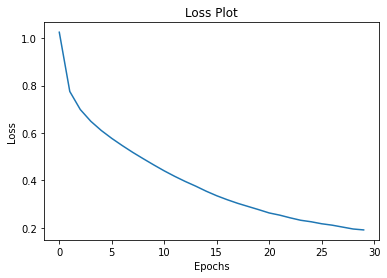

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape)) #在 8*8 之中找最大的 attention 的 block

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a plane taking off from a runway into the sky. <end>
Prediction Caption: a picture of a plane flies a kite. <end>


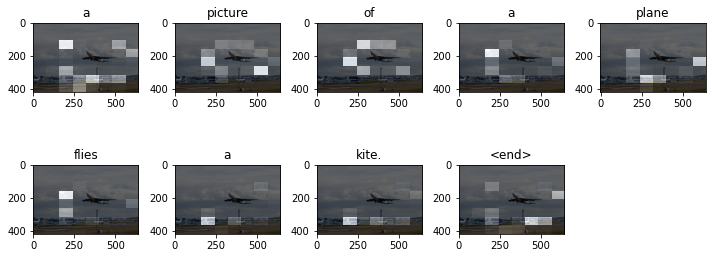

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


Prediction Caption: a man riding a wave out of the ocean <end>


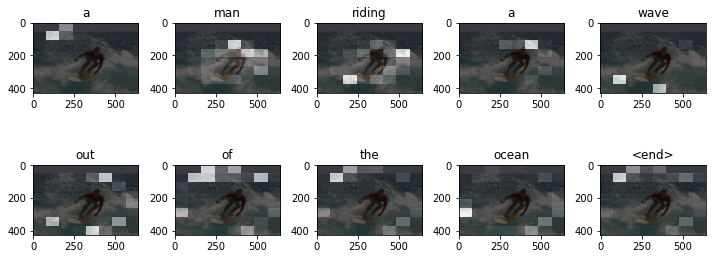

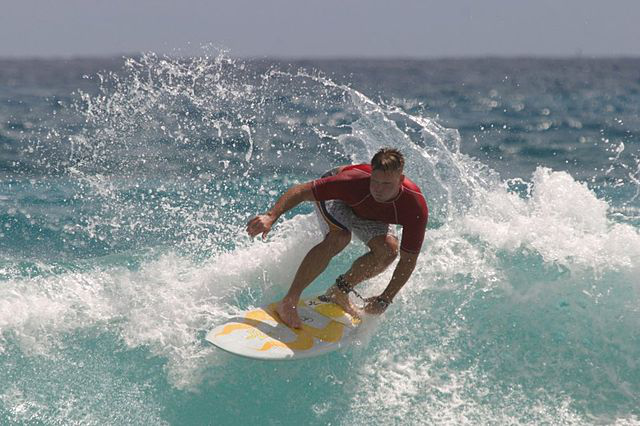

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)